In [1]:
import glob
import os
import shutil
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import neuron_morphology

In [3]:
neuron_morphology.__version__

'1.1.3'

In [4]:
# Morphology visualization imports
from neuron_morphology.swc_io import morphology_from_swc
from neuron_morphology.constants import AXON, BASAL_DENDRITE, SOMA

In [5]:
# Morphology feature extraction imports
from neuron_morphology.feature_extractor.data import Data
from neuron_morphology.feature_extractor.feature_extractor import FeatureExtractor
from neuron_morphology.feature_extractor.utilities import unnest
from neuron_morphology.features.default_features import default_features

In [6]:
# included 3 example swc files with errors for morph feature extraction
swc_files = glob.glob('./data/example_morphs/*_transformed.swc')

### Plotting example

In [7]:
def plot_morphology(file):#, output_path):
    morph = morphology_from_swc(file)
    
    axon_nodes = morph.get_node_by_types([AXON])
    dend_nodes = morph.get_node_by_types([BASAL_DENDRITE])
    soma_nodes = morph.get_node_by_types([SOMA])

    axon_x = [node['x'] for node in axon_nodes]
    axon_y = [node['y'] for node in axon_nodes]

    dend_x = [node['x'] for node in dend_nodes]
    dend_y = [node['y'] for node in dend_nodes]

    soma_x = [node['x'] for node in soma_nodes]
    soma_y = [node['y'] for node in soma_nodes]


    plt.figure(figsize=(10, 10))

    plt.scatter(axon_x, axon_y, s=1, edgecolor="none")
    plt.scatter(dend_x, dend_y, s=1, edgecolor="none")
    plt.scatter(soma_x, soma_y, s=20, c="black", edgecolor="none")


    plt.gca().set(xticks=[], yticks=[])
    plt.gca().set_aspect("equal")
    sns.despine(left=True, bottom=True)

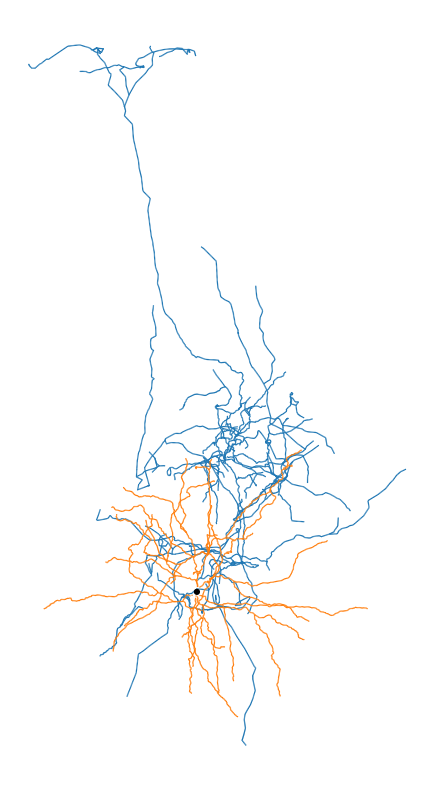

In [8]:
plot_morphology(swc_files[0])

In [9]:
import neuron_morphology.swc_io as swcio
from neuron_morphology.morphology import Morphology
from neuron_morphology.swc_io import morphology_from_swc
from neuron_morphology.feature_extractor.data import Data
from neuron_morphology.feature_extractor.feature_extractor import FeatureExtractor
from neuron_morphology.features.default_features import default_features
from neuron_morphology.constants import (
    SOMA, AXON, BASAL_DENDRITE, APICAL_DENDRITE
)

def prepare_neuron_tree(swc_data):
    nodes = swc_data.to_dict('records')

    replace_type = 2 # default node type
    for node in nodes:
        node['parent'] = int(node['parent'])
        node['id'] = int(node['id'])
        node['type'] = int(node['type'])

        if node['parent'] == -1 and node['type'] != 1:
            replace_type = node['type']

        if node['type'] == 1 and node['parent'] != -1:
            node['type'] = replace_type

    soma_list = []
    for node in nodes:
        if node['type'] == 1:
            soma_list.append(node)

    # create a new soma point
    if len(soma_list) > 1:
        x = 0
        y = 0
        z = 0
        n = len(soma_list)
        for node in soma_list:
            x += node['x']
            y += node['y']
            z += node['z']

        soma = copy.deepcopy(soma_list[0])
        soma['id'] = nodes[-1]['id']
        soma['x'] = x/n
        soma['y'] = y/n
        soma['z'] = z/n
        nodes.append(soma)

        for node in soma_list:
            node['parent'] = soma['id']
            node['type'] = replace_type
    
    return nodes

In [10]:
# load single file
swc_data = swcio.read_swc(swc_files[0])
nodes = prepare_neuron_tree(swc_data)
test_data = Data(Morphology(nodes, node_id_cb=lambda node: node['id'], parent_id_cb=lambda node: node['parent']))

In [11]:
# Feature Extractor 
fe = FeatureExtractor()
fe.register_features(default_features)
feature_extraction_run = fe.extract(test_data)
feature_extraction_run.results

2023-11-30 15:19:35,804 root         INFO     skipping mark (validation failed): type
2023-11-30 15:19:35,806 root         INFO     skipping mark (validation failed): type
2023-11-30 15:19:35,811 root         INFO     skipping mark (validation failed): type
2023-11-30 15:19:35,811 root         INFO     selected marks: <bound method FeatureExtractionRun.select_marks of <neuron_morphology.feature_extractor.feature_extraction_run.FeatureExtractionRun object at 0x7fe1c17a6c10>>
2023-11-30 15:19:35,811 root         INFO     skipping feature: apical_dendrite.compartment.dimension. Found extra marks: ['RequiresApical']
2023-11-30 15:19:35,812 root         INFO     skipping feature: apical_dendrite.tip.dimension. Found extra marks: ['RequiresApical']
2023-11-30 15:19:35,813 root         INFO     skipping feature: apical_dendrite.node.dimension. Found extra marks: ['RequiresApical']
2023-11-30 15:19:35,813 root         INFO     skipping feature: apical_dendrite.bifurcation.dimension. Found extr

2023-11-30 15:19:35,826 root         INFO     skipping feature: basal_dendrite.apical_dendrite.earth_movers_distance. Found extra marks: ['RequiresLayeredPointDepths', 'RequiresApical', 'RequiresReferenceLayerDepths']
2023-11-30 15:19:35,827 root         INFO     selected features: ['basal_dendrite.compartment.dimension', 'axon.compartment.dimension', 'all_neurites.compartment.dimension', 'dendrite.compartment.dimension', 'basal_dendrite.tip.dimension', 'axon.tip.dimension', 'all_neurites.tip.dimension', 'dendrite.tip.dimension', 'basal_dendrite.node.dimension', 'axon.node.dimension', 'all_neurites.node.dimension', 'dendrite.node.dimension', 'basal_dendrite.bifurcation.dimension', 'axon.bifurcation.dimension', 'all_neurites.bifurcation.dimension', 'dendrite.bifurcation.dimension', 'basal_dendrite.num_nodes', 'axon.num_nodes', 'all_neurites.num_nodes', 'dendrite.num_nodes', 'basal_dendrite.num_branches', 'axon.num_branches', 'all_neurites.num_branches', 'dendrite.num_branches', 'basal_d

ZeroDivisionError: division by zero

In [12]:
# list of other cells that failed morph feature extraction
failed_swc_extractions = pd.read_csv('./data/failed_extraction_swcs.csv')

In [13]:
failed_swc_extractions

,0
0,649387261_transformed.swc
1,759955697_transformed.swc
2,741796557_transformed.swc
3,667473785_transformed.swc
4,755625849_transformed.swc
...,...
278,863631899_transformed.swc
279,707162377_transformed.swc
280,648139266_transformed.swc
281,623434306_transformed.swc
